# BinSeg Segmentation
In this notebook, we use the BinSeg algorithm from the ruptures package to segment the challenge data.

In [16]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import ruptures as rpt
from sktime.annotation.plotting.utils import plot_time_series_with_change_points

from utils import load_data, to_submission

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we load the 250 time series (TS) as a pandas DataFrame. Each row corresponds to a twelve-dimensional TS and every column contains one channel of sensor data.

In [17]:
df = load_data()
# df.head()

For demonstration, we segment one channel and only a subset of the 250 TS. We plot the segmentations and store the change points (CPs) for the submission.

Using channel: y-acc


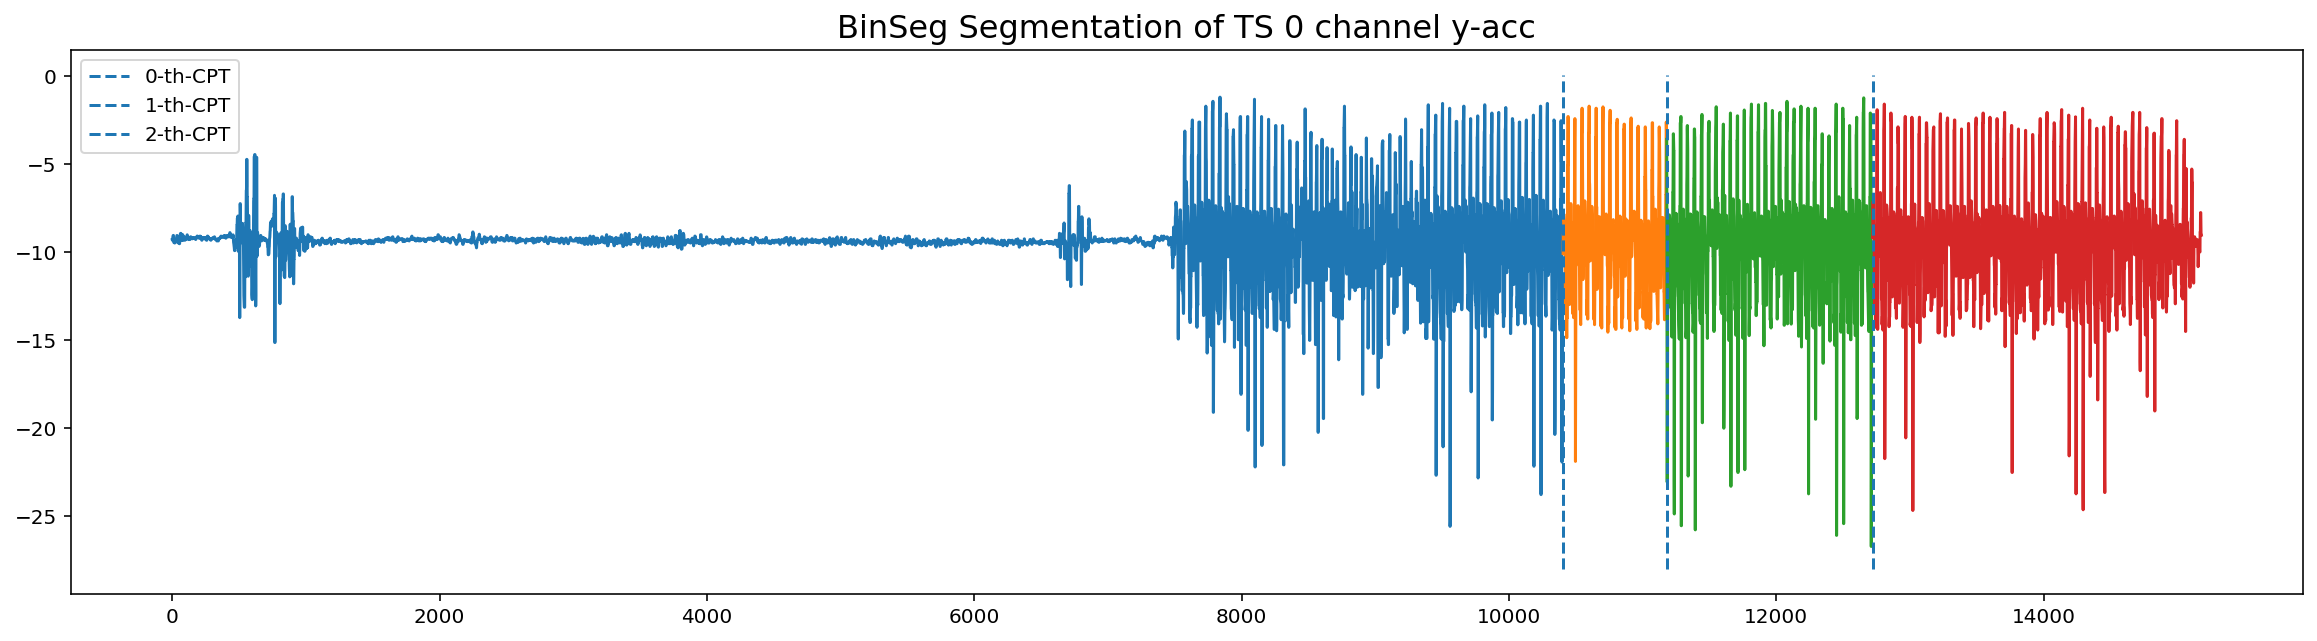

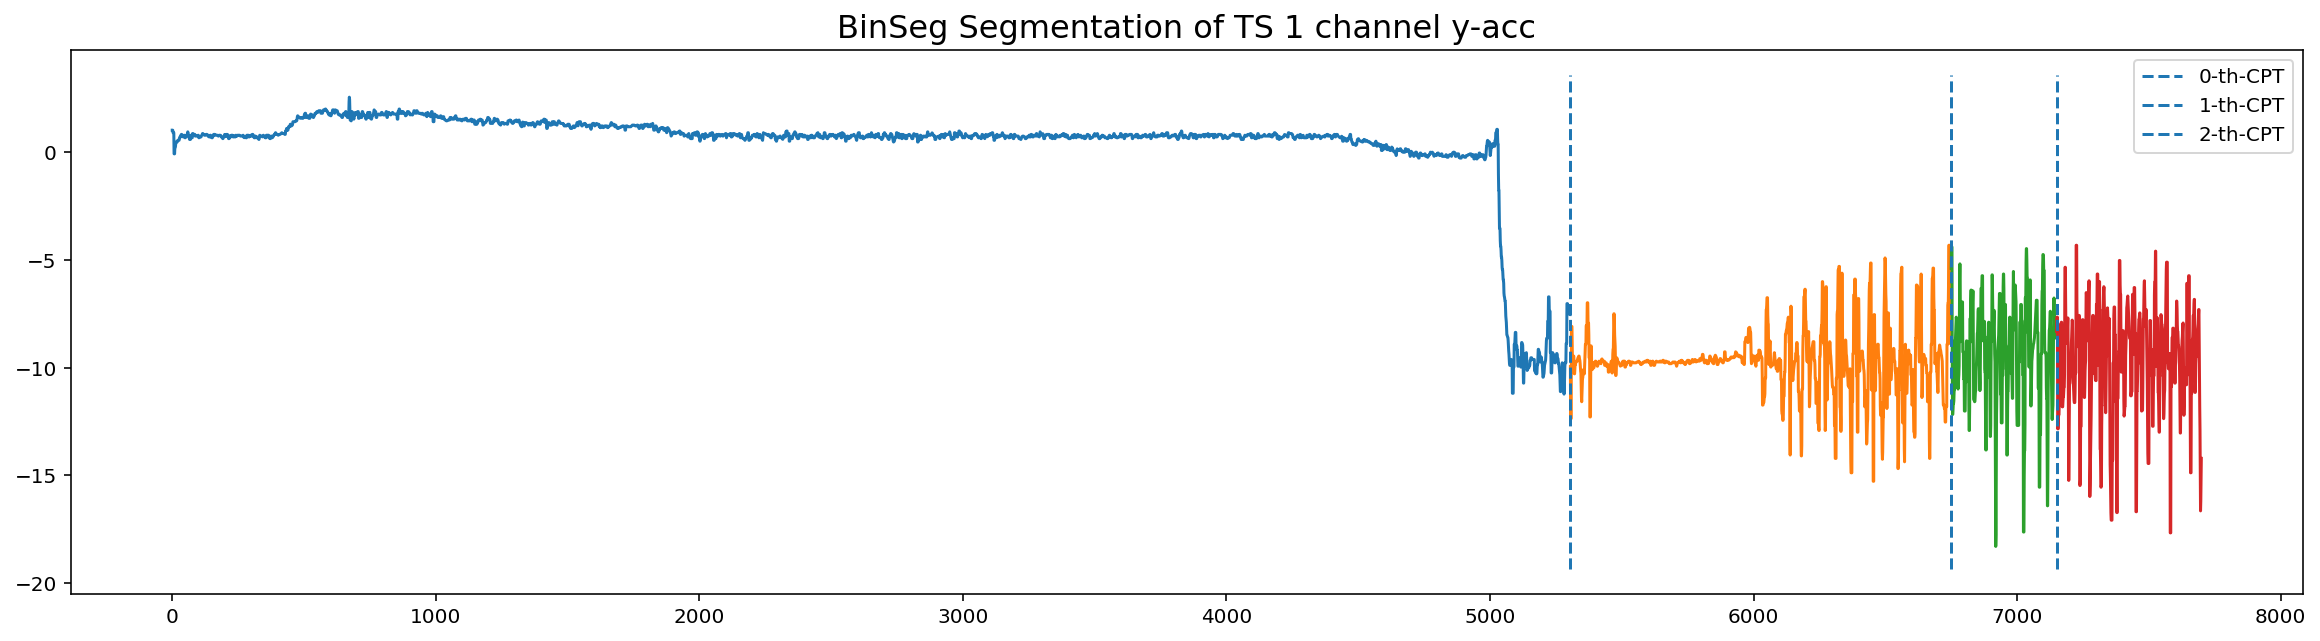

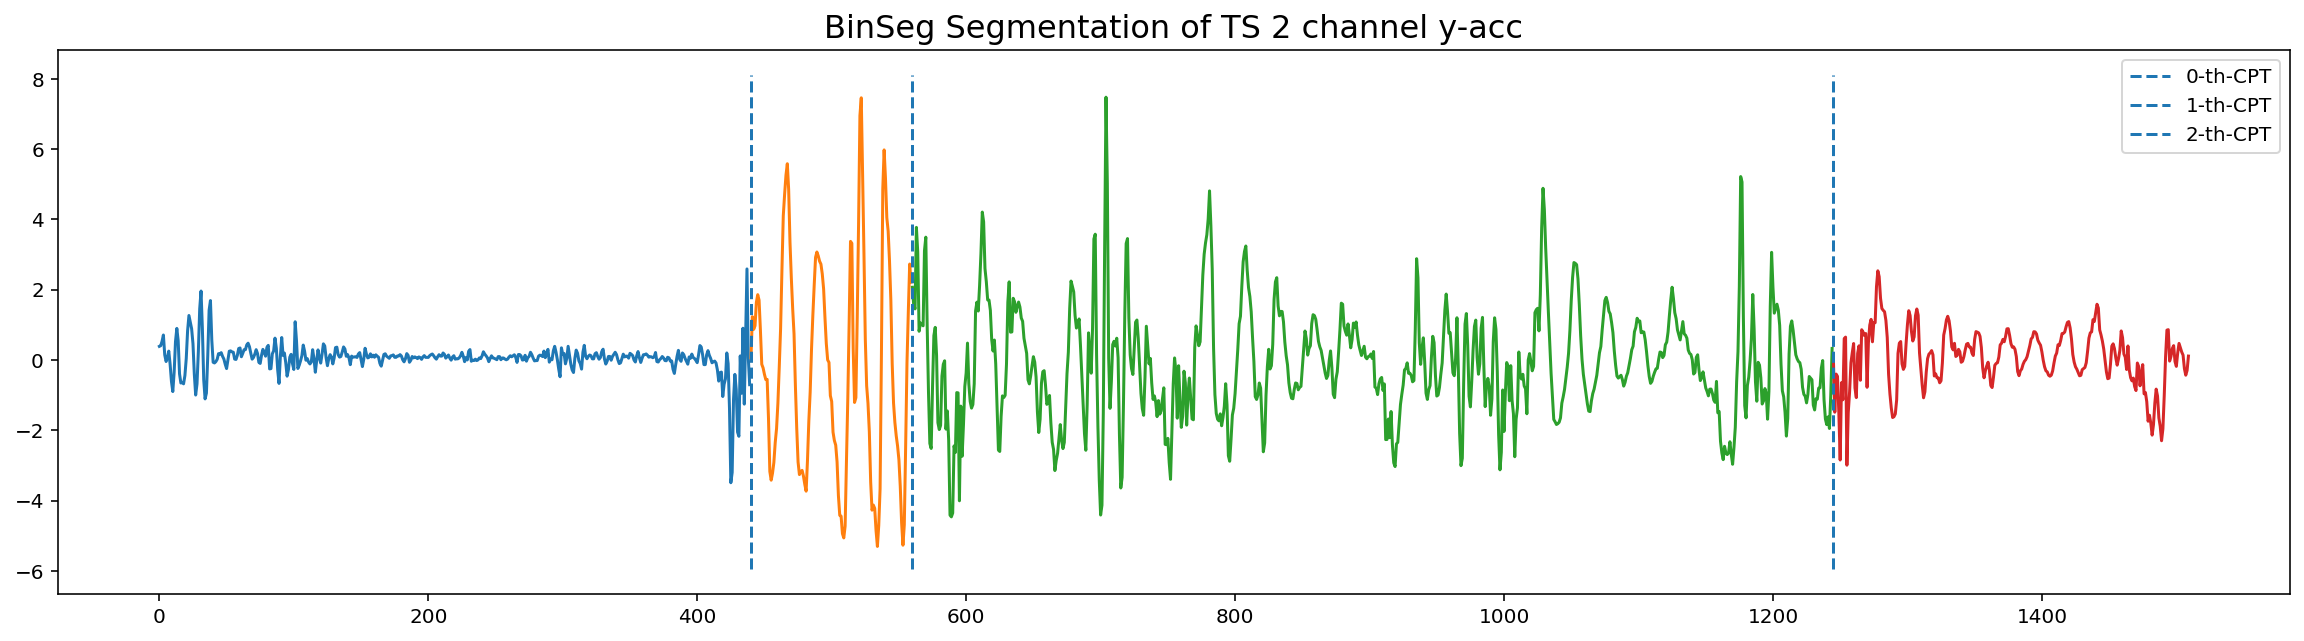

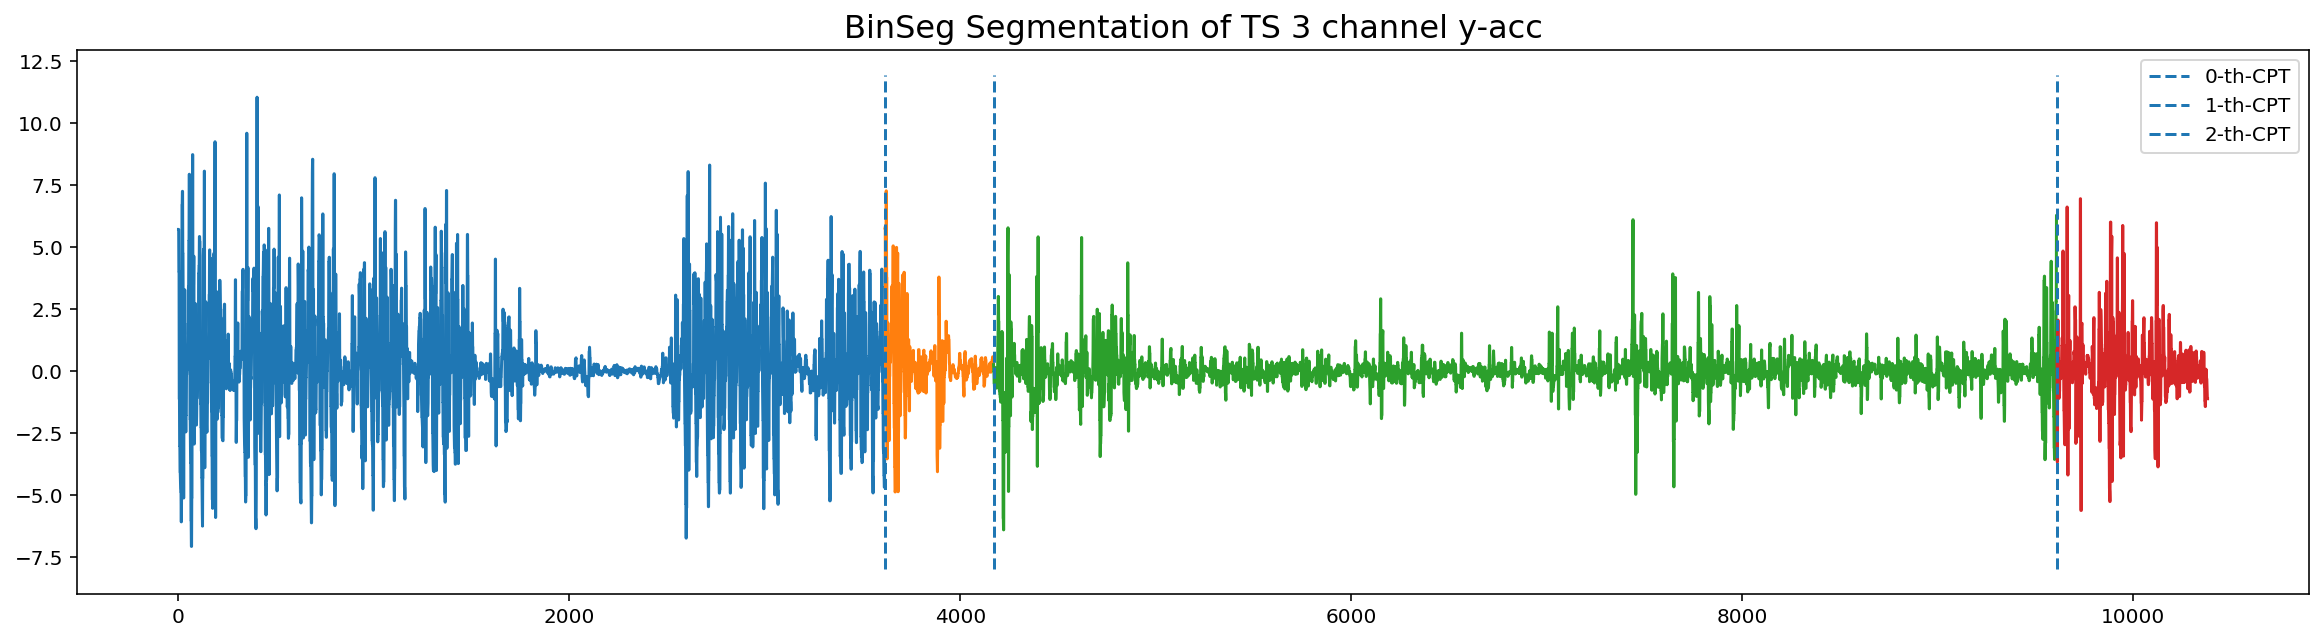

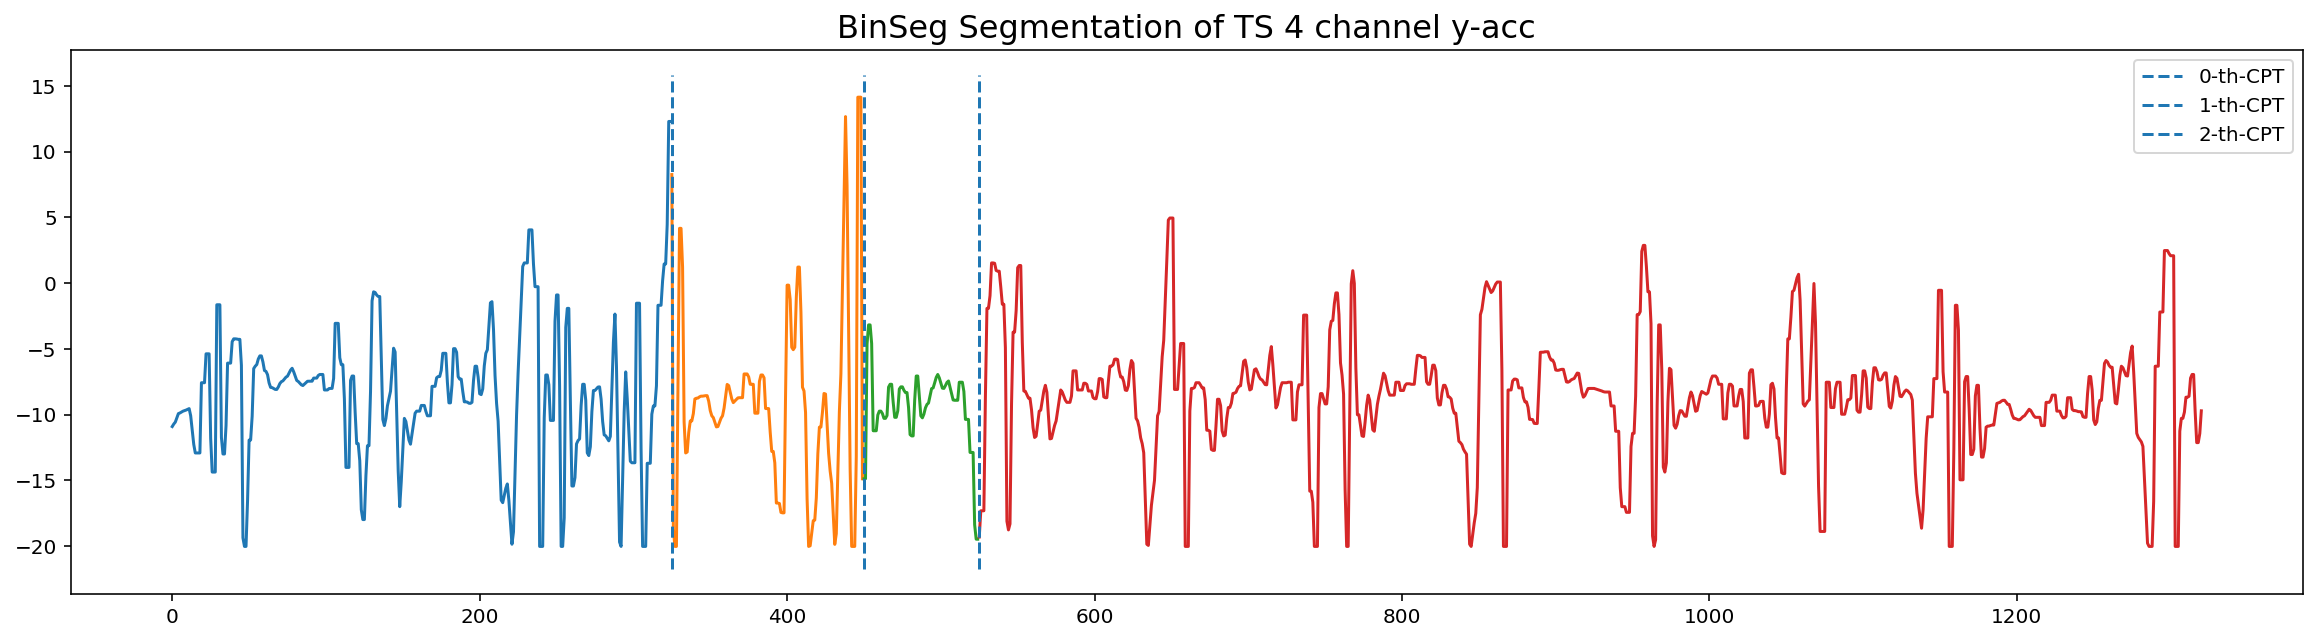

In [20]:
# use only one channel
channel = "y-acc"
# channels = ["x-acc", "y-acc", "z-acc", "x-gyro", "y-gyro", "z-gyro"]
print(f"Using channel: {channel}")

# segment the first 5 TS
subset = 5
change_points = []

for idx, row in df.iloc[:subset,:].iterrows():
    ts = row[channel]

    binseg = rpt.Binseg(model="ar", min_size=int(ts.shape[0] * .05)).fit(ts)
    found_cps = np.array(binseg.predict(n_bkps=3)[:-1], dtype=np.int64)
    change_points.append(found_cps)

    fig, ax = plot_time_series_with_change_points(
        f"BinSeg Segmentation of TS {idx} channel {channel}", pd.Series(ts), found_cps)

    plt.show()

To make a submission, simply run the last cell for all 250 TS and then format the CPs in the correct way and hand in your results.

In [19]:
submission = to_submission(df.iloc[:subset,:], change_points)
submission.head()
# submission.to_csv("submission.csv", index=False)

,ts_id,segment
0,0,1 10405
1,0,10406 775
2,0,11181 1540
3,0,12721 2459
4,1,1 5305
